In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report,
    f1_score, recall_score, roc_auc_score,
    precision_recall_curve, precision_score
)
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier

# Below are all the versions of the data that are not used in the final deliverable
df = pd.read_csv('../data/filtered_events_country_code.csv')
df2 = pd.read_csv('../data/filtered_events_country_code_brackets_removed.csv') 
df3 = pd.read_csv('../data/filtered_events_country_code_all_brackets_removed.csv')
df4 = pd.read_csv('../data/filtered_events_country_code_actor_split.csv')

In [2]:
# Final model using all of the removed brackets from the data

# Define violent
df4['violent'] = (
    (df4["sub_event_type"] == "Violent demonstration") |
    (df4["sub_event_type"] == "Excessive force against protesters")
).astype(int)

df4["event_id_prefix"] = df4["event_id_cnty"].astype(str).str[:3]

# Define features
features = ['event_id_prefix', 'assoc_actor_1']

X = df4[features]
y = df4['violent']

# Train the model and decide the train test split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Preprocessing with one hot encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), features),
    ],
    remainder='drop'
)

# Make it so that predicting 1 is more valuable compared to predicting 0 due to skew in data
class_weights = {0: 1, 1: 40}

# All of the models we use
models = {
    'XGBoost': XGBClassifier(
        n_estimators=2000,
        max_depth=10,
        learning_rate=0.04,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=class_weights[0] / class_weights[1],
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1,
    ),
    'Random_Forest': RandomForestClassifier(
        n_estimators=2000,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight=class_weights,
        random_state=42,
        n_jobs=-1,
    ),
    'Gradient_Boosting': GradientBoostingClassifier(
        n_estimators=500,
        max_depth=8,
        learning_rate=0.05,
        subsample=0.8,
        random_state=42,
    ),
    'Logistic_Regression': LogisticRegression(
        max_iter=3000,
        random_state=42,
        class_weight=class_weights,
        C=0.15,
        solver='liblinear'
    )
}

# Whole evaluation of the model including f1 score, f2 score, recall, precision and ROC-AUC
def evaluate_model_with_threshold(model, model_name):
    print(f"\n{'='*60}")
    print(f"{model_name}:")
    print(f"{'='*60}")
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    pipeline.fit(X_train, y_train)
    y_proba = pipeline.predict_proba(X_val)[:, 1]
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_proba)
    f2_scores = 5 * (precision * recall) / (4 * precision + recall + 1e-8)
    best_idx = np.argmax(f2_scores)
    best_threshold = thresholds[best_idx]
    best_f2 = f2_scores[best_idx]
    
    print(f"Best threshold for F2 score: {best_threshold:.2f} with F2: {best_f2:.3f}")

    y_pred = (y_proba > best_threshold).astype(int)
    
    cm = confusion_matrix(y_val, y_pred)
    print("\nConfusion Matrix:")
    print(pd.DataFrame(
        cm,
        index=['Actual 0', 'Actual 1'],
        columns=['Pred 0', 'Pred 1']
    ))
    
    print("\nReport:")
    print(classification_report(y_val, y_pred, digits=4, zero_division=0))
    
    f1_class_0 = f1_score(y_val, y_pred, pos_label=0, zero_division=0)
    f1_class_1 = f1_score(y_val, y_pred, pos_label=1, zero_division=0)
    print(f"F1 Score (class 0): {f1_class_0:.4f}")
    print(f"F1 Score (class 1): {f1_class_1:.4f}")
    
    recall_metric = recall_score(y_val, y_pred, zero_division=0)
    print(f"Recall (class 1): {recall_metric:.4f}")

    precision_metric = precision_score(y_val, y_pred, zero_division=0)
    print(f"Precision (class 1): {precision_metric:.4f}")
    
    roc_auc = roc_auc_score(y_val, y_proba)
    print(f"ROC-AUC score: {roc_auc:.4f}")

    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring='roc_auc', n_jobs=-1)
    print(f"Cross-validation ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    
    return pipeline, y_pred, y_proba, best_threshold, roc_auc, cv_scores.mean()

results = {}
for name, model in models.items():
    pipeline, y_pred, y_proba, threshold, roc_auc_val, cv_roc_auc = evaluate_model_with_threshold(model, name)
    results[name] = {
        'pipeline': pipeline,
        'y_pred': y_pred,
        'y_proba': y_proba,
        'best_threshold': threshold,
        'roc_auc_val': roc_auc_val,
        'cv_roc_auc': cv_roc_auc
    }

# From logistic regression, get the features that are deemed as the most important for predicting violence/ 1
logreg_pipeline = results['Logistic_Regression']['pipeline']
logreg_clf = logreg_pipeline.named_steps['classifier']

if hasattr(logreg_clf, 'coef_'):
    all_transformed_features = []
    if hasattr(preprocessor, 'named_transformers_'):
        for name, _, original_cols in preprocessor.transformers:
            if name == 'cat':
                all_transformed_features.extend(
                    preprocessor.named_transformers_['cat'].get_feature_names_out(original_cols)
                )

    coefs = logreg_clf.coef_[0]
    coef_df = pd.DataFrame({
        'feature': all_transformed_features,
        'coef': coefs
    }).sort_values('coef', ascending=False)



XGBoost:


C:\Users\stanv\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [15:52:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best threshold for F2 score: 0.00 with F2: 0.240

Confusion Matrix:
          Pred 0  Pred 1
Actual 0   69288    3657
Actual 1    1189     523

Report:
              precision    recall  f1-score   support

           0     0.9831    0.9499    0.9662     72945
           1     0.1251    0.3055    0.1775      1712

    accuracy                         0.9351     74657
   macro avg     0.5541    0.6277    0.5719     74657
weighted avg     0.9635    0.9351    0.9481     74657

F1 Score (class 0): 0.9662
F1 Score (class 1): 0.1775
Recall (class 1): 0.3055
Precision (class 1): 0.1251
ROC-AUC score: 0.7520
Cross-validation ROC-AUC: 0.7400 (+/- 0.0059)

Random_Forest:
Best threshold for F2 score: 0.52 with F2: 0.255

Confusion Matrix:
          Pred 0  Pred 1
Actual 0   67657    5288
Actual 1    1059     653

Report:
              precision    recall  f1-score   support

           0     0.9846    0.9275    0.9552     72945
           1     0.1099    0.3814    0.1707      1712

    accuracy  


Top 15 Features Pushing Toward Class 1 (Violent):
                                                       feature     coef
                                         assoc_actor_1_Rioters 4.747555
                                       assoc_actor_1_Prisoners 4.399372
                                      assoc_actor_1_Black Bloc 3.941027
                            assoc_actor_1_PA: Palestine Action 3.818448
                                       assoc_actor_1_Civilians 3.434896
                                 assoc_actor_1_Shut the System 3.420836
                                 assoc_actor_1_No TAV Movement 3.385251
                               assoc_actor_1_MiB: Men in Black 3.299024
        assoc_actor_1_AUR: Alliance for the Union of Romanians 3.155369
                                 assoc_actor_1_Anarchist Group 3.137684
assoc_actor_1_Former Military Forces of Bosnia and Herzegovina 3.107117
                    assoc_actor_1_PMP: People's Movement Party 3.085825
             

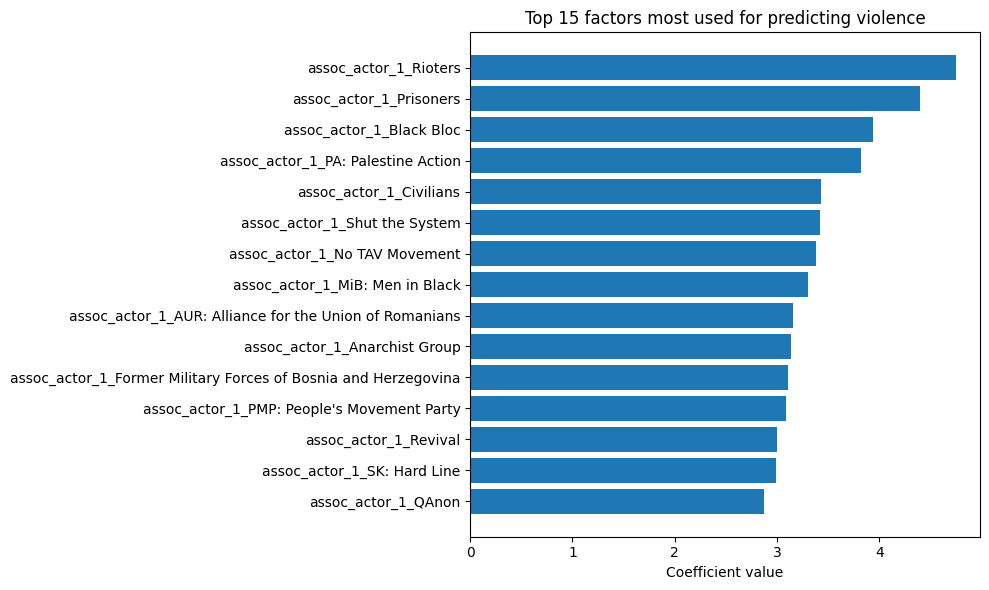

In [3]:
print("\nTop 15 Features Pushing Toward Class 1 (Violent):")
print(coef_df.head(15).to_string(index=False))

# Plotting of the top factors leading to violence/ 1
plt.figure(figsize=(10, 6))
top_positive = coef_df.head(15)
plt.barh(top_positive['feature'][::-1], top_positive['coef'][::-1])
plt.title("Top 15 factors most used for predicting violence")
plt.xlabel("Coefficient value")
plt.tight_layout()
plt.show()


Top 15 Important Features for XGBoost:
                                                               feature  importance
                                         assoc_actor_1_No TAV Movement    0.061945
                                                   event_id_prefix_SWE    0.058937
                                 assoc_actor_1_FFF: Fridays for Future    0.052728
                                                   event_id_prefix_GRC    0.051941
                                       assoc_actor_1_Palestinian Group    0.049413
                                                   event_id_prefix_POL    0.047338
                                          assoc_actor_1_Health Workers    0.042134
                         assoc_actor_1_PD: Democratic Party of Albania    0.038195
                                     assoc_actor_1_Romani Ethnic Group    0.037843
                                assoc_actor_1_XR: Extinction Rebellion    0.031388
                                              a

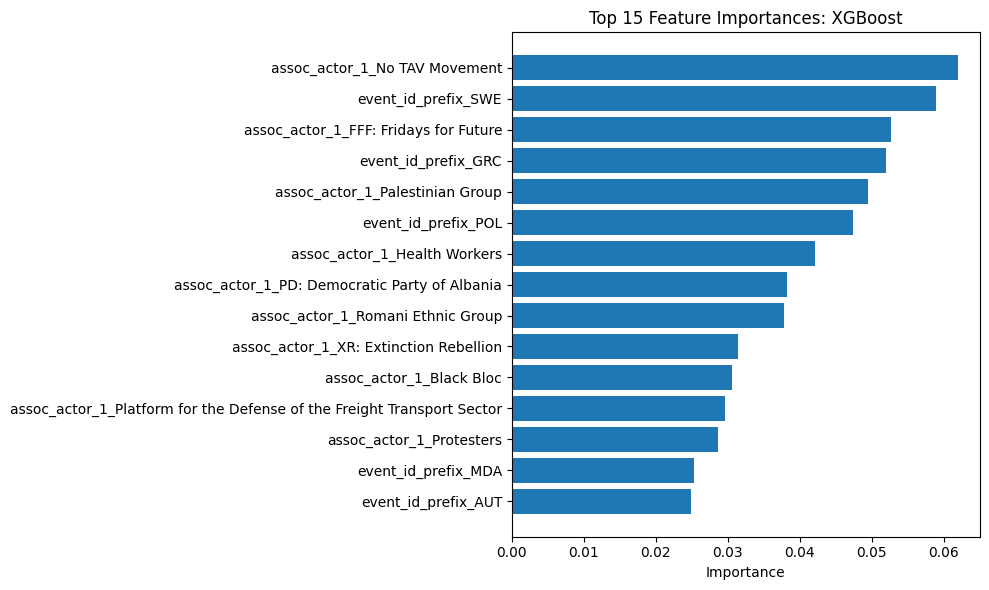


Top 15 Important Features for Random_Forest:
                              feature  importance
                  event_id_prefix_GRC    0.157121
                    assoc_actor_1_nan    0.063604
                  event_id_prefix_FRA    0.060676
                  event_id_prefix_ITA    0.051954
        assoc_actor_1_Anarchist Group    0.044030
                  event_id_prefix_SWE    0.042709
                  event_id_prefix_POL    0.040856
              assoc_actor_1_Prisoners    0.028055
                  event_id_prefix_ALB    0.023847
                  assoc_actor_1_Women    0.022999
assoc_actor_1_FFF: Fridays for Future    0.022898
         assoc_actor_1_Health Workers    0.022592
            assoc_actor_1_Labor Group    0.021332
                 assoc_actor_1_Antifa    0.019980
                  event_id_prefix_ESP    0.016494


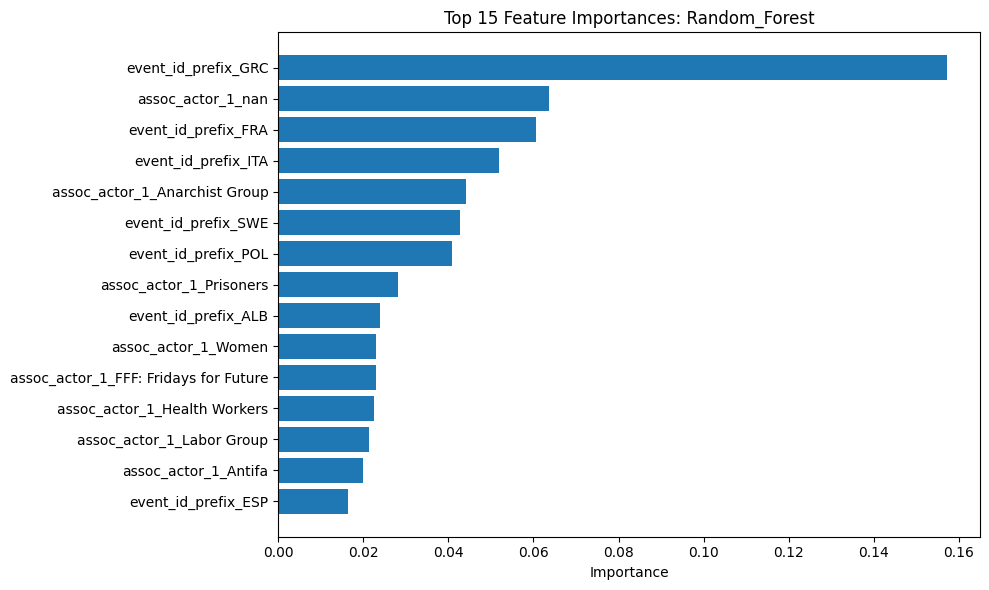


Top 15 Important Features for Gradient_Boosting:
                           feature  importance
               event_id_prefix_GRC    0.149583
             assoc_actor_1_Rioters    0.056076
           assoc_actor_1_Prisoners    0.053362
                 assoc_actor_1_nan    0.052201
     assoc_actor_1_Anarchist Group    0.050295
               event_id_prefix_FRA    0.048093
          assoc_actor_1_Black Bloc    0.033452
assoc_actor_1_PA: Palestine Action    0.024077
               event_id_prefix_ALB    0.022551
 assoc_actor_1_Romani Ethnic Group    0.019027
              assoc_actor_1_Antifa    0.018125
     assoc_actor_1_No TAV Movement    0.016478
             assoc_actor_1_Farmers    0.013529
     assoc_actor_1_Shut the System    0.012006
               event_id_prefix_ITA    0.011891


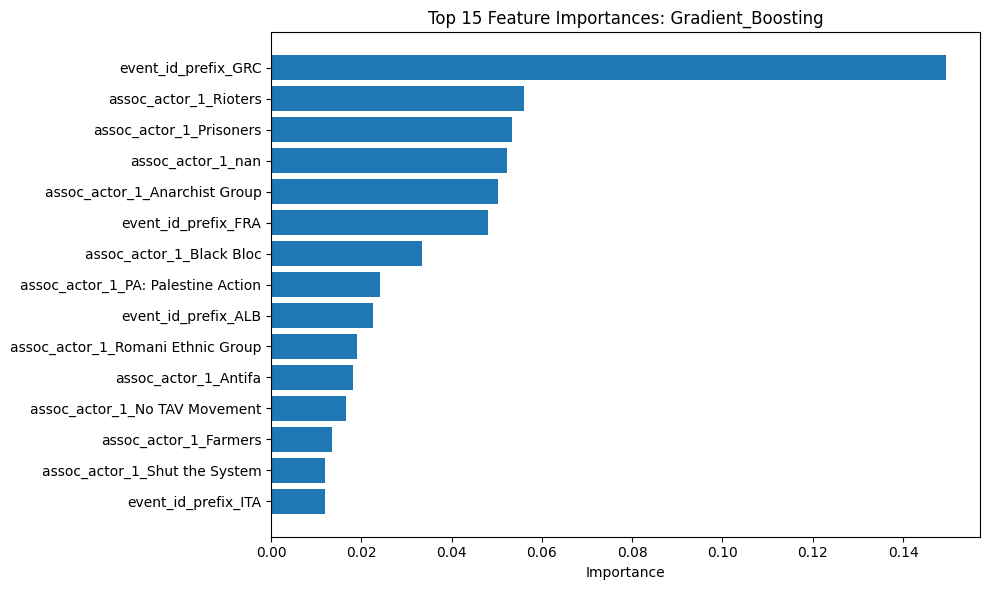

In [4]:
# Find the importance of the features (not for predicting violence/ 1 since this is not logistic regression)
all_transformed_features = []
if hasattr(preprocessor, 'named_transformers_'):
    for name, _, original_cols in preprocessor.transformers:
        if name == 'cat':
            all_transformed_features.extend(
                preprocessor.named_transformers_['cat'].get_feature_names_out(original_cols)
            )

tree_model_names = ['XGBoost', 'Random_Forest', 'Gradient_Boosting']

for model_name in tree_model_names:
    pipeline = results[model_name]['pipeline']
    clf = pipeline.named_steps['classifier']
    
    if hasattr(clf, 'feature_importances_'):
        importances = clf.feature_importances_
        
        feature_importance_df = pd.DataFrame({
            'feature': all_transformed_features,
            'importance': importances
        }).sort_values('importance', ascending=False)

        print(f"\nTop 15 Important Features for {model_name}:")
        print(feature_importance_df.head(15).to_string(index=False))

        # Plotting of the top featues
        plt.figure(figsize=(10, 6))
        top_features = feature_importance_df.head(15)
        plt.barh(top_features['feature'][::-1], top_features['importance'][::-1])
        plt.title(f"Top 15 Feature Importances: {model_name}")
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.show()
